<a href="https://colab.research.google.com/github/Hrishikap/hrishika_pycbc/blob/main/miller_h_plus_h_cross.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-65-3368563681>:111: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 1200x600 with 0 Axes>

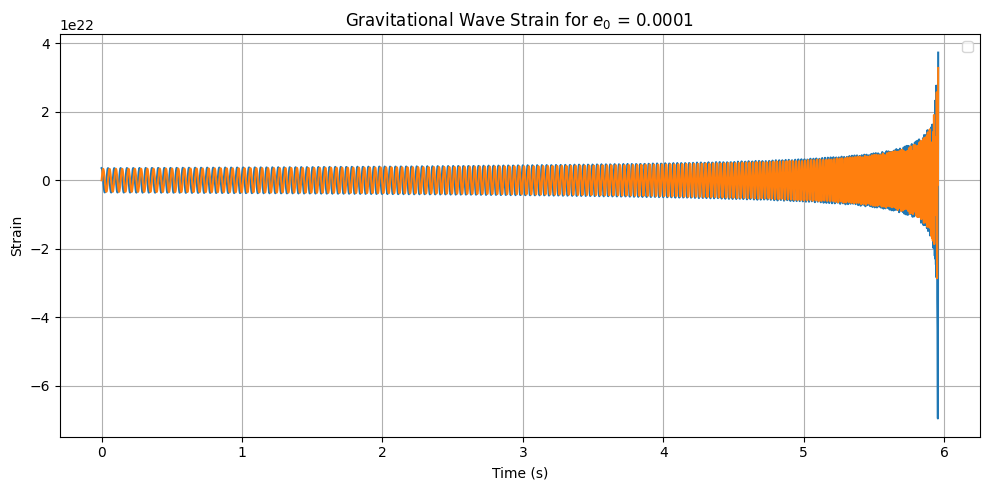

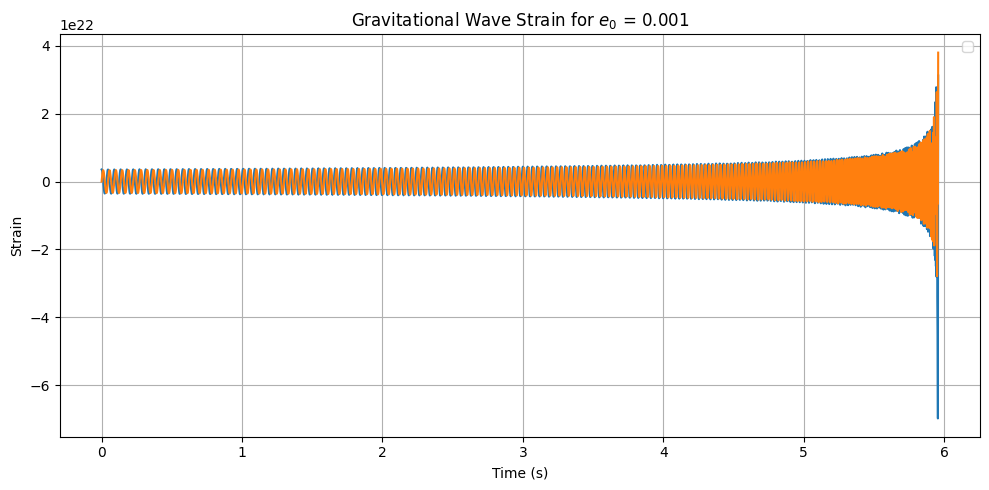

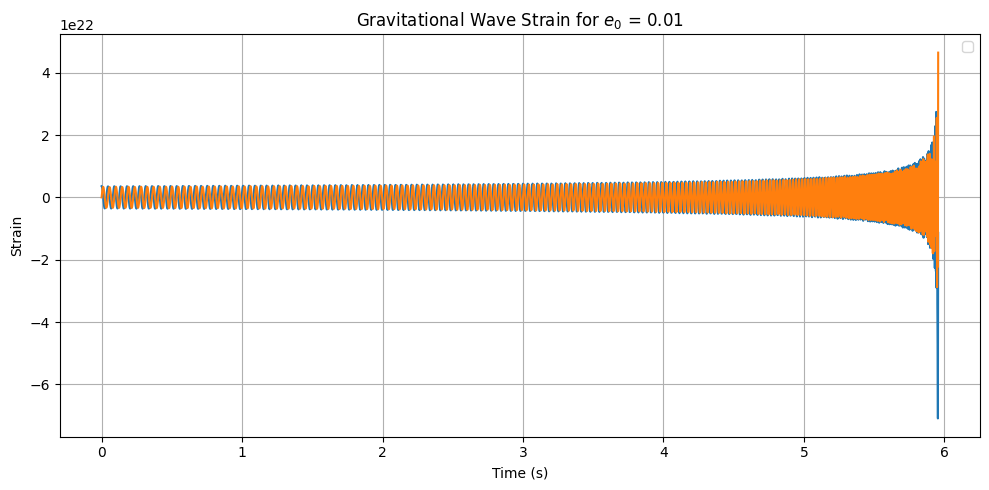

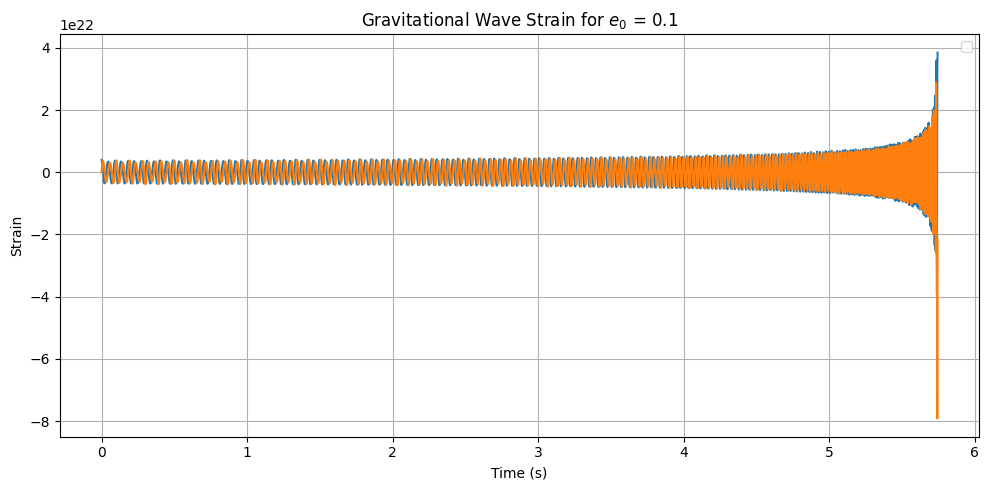

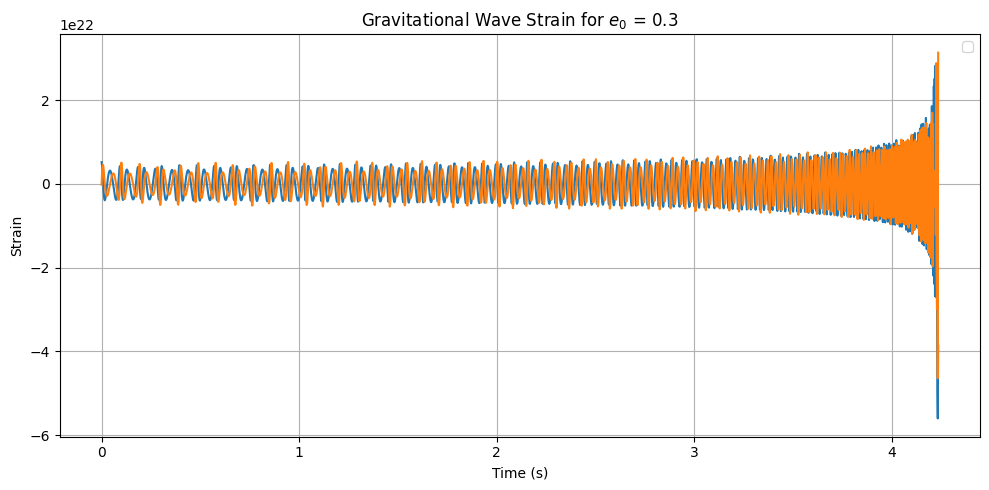

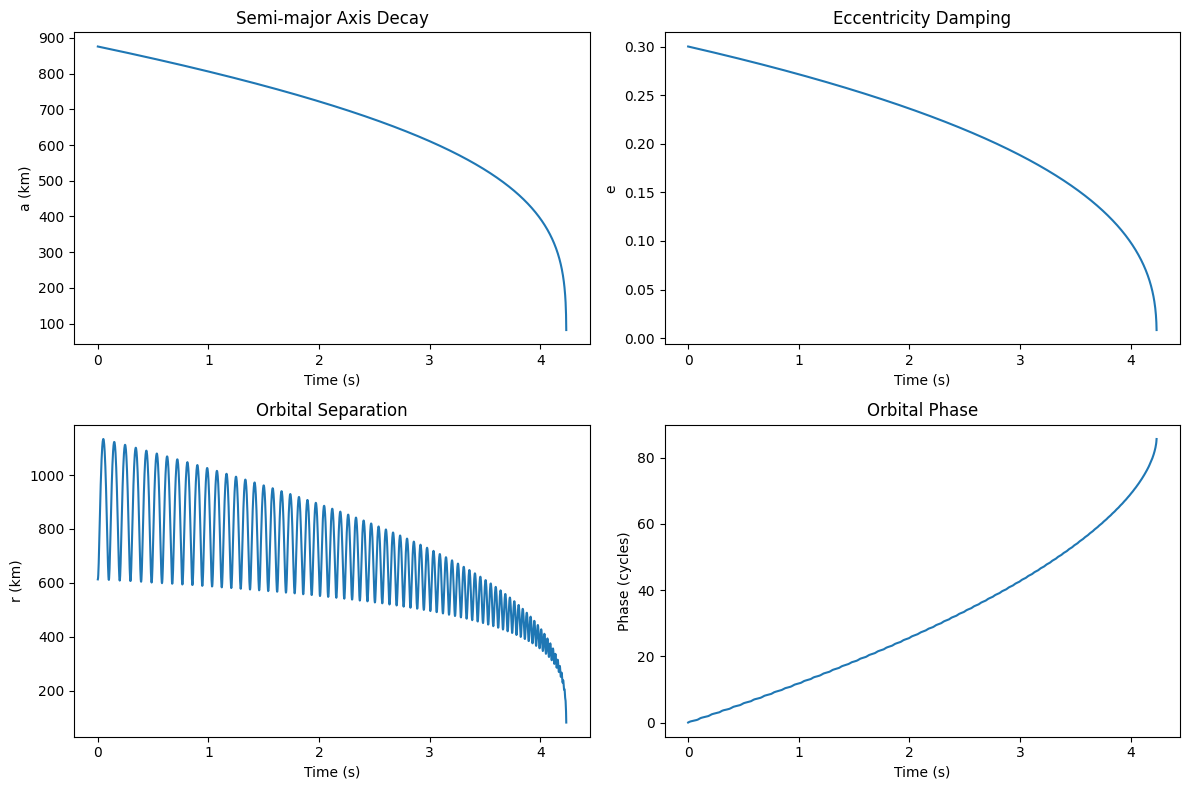

In [65]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ─── Constants ───────────────────────────────────────────────────────────────
G     = 6.67430e-11       # m^3 kg^-1 s^-2
c     = 299792458.0       # m/s
M_sun = 1.98847e30        # kg

# ─── Binary masses (SI) ──────────────────────────────────────────────────────
m1 = 10 * M_sun
m2 = 10 * M_sun
M  = m1 + m2
μ  = m1*m2/M
D=1000e6*3.086e16

# ─── Initial orbital elements ────────────────────────────────────────────────
P0   = 0.1           # orbital period in seconds
a0   = (G*M*(P0/(2*np.pi))**2)**(1/3)
Ψ0   = 0.0                # true anomaly
theta=np.pi/4
eccentricities = [0.0001, 0.001, 0.01, 0.1, 0.3]  # whatever range you want

# ─── Time span & sampling ────────────────────────────────────────────────────
t_start = 0.0
t_end   = 150.0          # seconds
orbits  = (t_end - t_start)/P0
pts_per = 50
t_eval   = np.linspace(t_start, t_end, int(orbits*pts_per))

# ─── ODE system ──────────────────────────────────────────────────────────────
def deriv(t, y):
    r, a, e, Ψ, Φ = y

    # GW back-reaction (Peters 1964)
    a_dot = - (64/5) * G**3/(c**5) * (m1*m2*M) / a**3 \
            * (1 + 73/24*e**2 + 37/96*e**4) * (1-e**2)**(-7/2)
    e_dot = - (304/15)* G**3/(c**5) * (m1*m2*M) / a**4 * e \
            * (1 + 121/304*e**2) * (1-e**2)**(-5/2)

    # True anomaly rate
    Ψ_dot = np.sqrt(G*M/a**3) * (1 - e**2)**(-1.5) * (1 + e*np.cos(Ψ))**2

    # Periastron precession + Keplerian phase
    Φ_dot = Ψ_dot + 3 * (G*M)**1.5 / (c**2 * a**2.5 * (1 - e**2))

    # Radial derivative from r = a(1−e²)/(1 + e cosΨ)
    C1 = (1 - e**2)*a_dot / (1 + e*np.cos(Ψ))
    C2 = -2*a*e*e_dot    / (1 + e*np.cos(Ψ))
    C3 = -a*(1 - e**2)*( e_dot*np.cos(Ψ) -e*np.sin(Ψ)*Ψ_dot) \
         / (1 + e*np.cos(Ψ))**2
    r_dot = C1 + C2 + C3

    return [r_dot, a_dot, e_dot, Ψ_dot, Φ_dot]

plt.figure(figsize=(12, 6))

for e0 in eccentricities:
    # Initial orbital separation for given e0
    r0 = a0*(1 - e0**2)/(1 + e0*np.cos(Ψ0))

    # Initial condition vector
    y0 = [r0, a0, e0, Ψ0, 0.0]

    # Integrate
    sol = solve_ivp(deriv,
                    [t_start, t_end],
                    y0,
                    method='Radau',
                    t_eval=t_eval,
                    rtol=1e-8, atol=1e-10)

    # Compute derivatives from the solution
    r_dot = np.gradient(sol.y[0], sol.t)
    phi_dot = np.gradient(sol.y[4], sol.t)
    phi_ddot = np.gradient(phi_dot, sol.t)
    r_ddot = np.gradient(r_dot, sol.t)

    # Use the integrated values for r and Phi (Φ)
    r = sol.y[0]
    Phi = sol.y[4]

    # h_plus strain calculation
    h_plus = (
        (μ / (2 * D)) * (
            ((1 - 2 * np.cos(2 * theta)) * np.cos(Phi)**2 - 3 * np.cos(2 * Phi)) * r_dot**2 +
            (3 + np.cos(2 * theta)) * (2 * np.cos(2 * Phi) * phi_dot**2 + np.sin(2 * Phi) * phi_ddot) * r**2 +
            4 * (
                (3 + np.cos(2 * theta)) * np.sin(2 * Phi) * phi_dot * r_dot +
                ((1 - 2 * np.cos(2 * theta)) * np.cos(Phi)**2 - 3 * np.cos(2 * Phi)) * r_ddot
            ) * r
        )
    )

    # h_cross strain calculation
    h_cross = (
        (-2 * μ * np.cos(theta) / D) * (
            np.sin(2 * Phi) * r_dot**2 +
            (np.cos(2 * Phi) * phi_ddot - 2 * np.sin(2 * Phi) * phi_dot**2) * r**2 +
            (4 * np.cos(2 * Phi) * phi_dot * r_dot + np.sin(2 * Phi) * r_ddot) * r
        )
    )
    # Plot h_plus for this eccentricity on the same figure
    plt.figure(figsize=(10, 5))
    plt.plot(sol.t, h_plus)
    # You might also want to plot h_cross if needed:
    plt.plot(sol.t, h_cross)
    plt.xlabel('Time (s)')
    plt.ylabel('Strain')
    plt.title(rf'Gravitational Wave Strain for $e_0$ = {e0}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
fig, axes = plt.subplots(2, 2, figsize=(12,8))

# a(t)
axes[0,0].plot(sol.t, sol.y[1]/1e3)
axes[0,0].set_xlabel('Time (s)')
axes[0,0].set_ylabel('a (km)')
axes[0,0].set_title('Semi-major Axis Decay')

# e(t)
axes[0,1].plot(sol.t, sol.y[2])
axes[0,1].set_xlabel('Time (s)')
axes[0,1].set_ylabel('e')
axes[0,1].set_title('Eccentricity Damping')

# r(t)
axes[1,0].plot(sol.t, sol.y[0]/1e3)
axes[1,0].set_xlabel('Time (s)')
axes[1,0].set_ylabel('r (km)')
axes[1,0].set_title('Orbital Separation')

# Φ(t)
axes[1,1].plot(sol.t, sol.y[4]/(2*np.pi))
axes[1,1].set_xlabel('Time (s)')
axes[1,1].set_ylabel('Phase (cycles)')
axes[1,1].set_title('Orbital Phase')

plt.tight_layout()
plt.show()
